In [1]:
# Seth Hughes
# May 15, 2020
# Notebook for beginning LSTM exploration with FOREX data

A good practice -- in my opinion -- is to always import these first two libraries at the beginning of any Python implementation; good chance you'll have to use them at some point

I set the tensorflow logging level to '3' to only show errors; if you don't do this, you'll get a lot of annoying tensorflow related messages on the command line and underneat the cell in the notebook

These messages are probably informative, but not for an elementary user like me

I then import keras *from* tensorflow; I don't import the standalone keras library; this should be done when using tensorflow version 2.0 or later

Finally, I run the simple line of code at the end to verify that tensorflow is going to run on my GPU; if that line returns zero (0) then your tensorflow is going to run on your CPU

In [2]:
import os
import sys

# Set tensorflow logging to show errors only ('3')
# '0' = debug; '1' = info; '2' = warning; '3' = error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras

# Print out version(s) just for sanity check
print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

# Verify that tensorflow is running on the available GPU
print('Num GPUs Available:', len(tf.config.experimental.list_physical_devices('GPU')), '\n')

Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:22:21) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf
Num GPUs Available: 1 



I downloaded EUR/GBP historical data from Yahoo financial
It gives OHLC, adjusted close, and volume (volume was always zero (0) in this data, so maybe they don't track it?)

I saved the spreadsheet in my local directory for recurrent neural networks that I have created

I read in the data using pandas, and then print out the last five datapoints using the 'tail()' function; if you wanted to read the first five rows, simply replace 'tail()' with 'head()'

In [20]:
import pandas as pd

curr_dir = os.getcwd() # get current directory
print('Current directory:', curr_dir)

df_forex = pd.read_csv(os.path.join(curr_dir, 'eurgbp.csv'), engine='python') # read data into pandas dataframe
df_forex.tail() # print the last few rows of data

Current directory: C:\Anaconda3\RNN


,Date,Open,High,Low,Close,Adj Close,Volume
2605,2020-05-11,0.87274,0.88033,0.87218,0.87280,0.87280,0.0
2606,2020-05-12,0.87644,0.88349,0.87595,0.87660,0.87660,0.0
2607,2020-05-13,0.88508,0.88760,0.88083,0.88514,0.88514,0.0
2608,2020-05-14,0.88409,0.88694,0.88327,0.88397,0.88397,0.0
2609,2020-05-15,0.88327,0.89334,0.88272,0.89259,0.89259,0.0


I simply plot the OHLC data, nothing fancy 

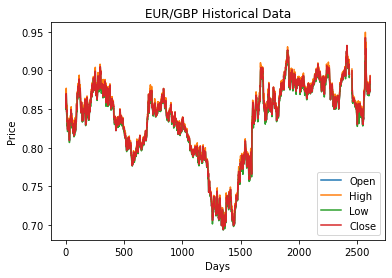

In [21]:
# Plotting out the data
# Order: open, high, low, close

from matplotlib import pyplot as plt

plt.figure()
plt.plot(df_forex['Open'])
plt.plot(df_forex['High'])
plt.plot(df_forex['Low'])
plt.plot(df_forex['Close'])
plt.title('EUR/GBP Historical Data')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Open', 'High', 'Low', 'Close'], loc='lower right')
plt.show()

Here, I check for null values and print out how many I have

Then, I drop these null values and create a *new* dataframe without the null values

You don't have to do it this way, but it at least keeps your orignal data in its original form if you want to use it again quickly, so a good practice for someone like me who is apt to mess up

In [25]:
# Checking for null values
print('How many null values are present:', df_forex.isna().sum())


# Drop any null values and place modified data into new dataframe
forex_new = df_forex.dropna(axis=0, how='any')

print('How many null values are present:', forex_new.isna().sum())

How many null values are present: Date          0
Open         23
High         23
Low          23
Close        23
Adj Close    23
Volume       23
dtype: int64
How many null values are present: Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


The next two cells contain functions that I will use to gather the data in such a way that the lstm can use them

LSTMs need a 3d-array with features: (batch_size, time_steps, features); I set the time_steps to three, and explain what that signifies in the code comments

This function will return x and y data to be used in the LSTM

The second function trims the dataset so that it is divisible by time_steps; nothing fancy

In [48]:
# LSTMs consume input in a 3-d array: [batch_size, time_steps, features]
# Using three (3) as the timestep for first model
# Thus, the model will use samples 0 - 2 as its first input and close price of sample 3 is the output

def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that will act as output column
    # total number of time-series samples is len(mat) - time_steps
    dim_0 = mat.shape[0] - time_steps # dimension zero
    dim_1 = mat.shape[1] # dimension one
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:time_steps + i]
        y[i] = mat[time_steps + i, y_col_index]
    print('Length of time-series:', x.shape, y.shape)
    return x, y

In [49]:
# Function to drop samples if the number of samples is not divisible by batch size

def trim_dataset(mat, batch_size):
    no_dropped = mat.shape[0] % batch_size
    print('Amount of rows to be dropped:', no_dropped)
    if(no_dropped > 0):
        return mat[:-no_dropped]
    else:
        return mat

Here, I create my training and validation data; I then normalize it, which is standard

In the cell after the one below, I do the same for the testing data

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ['Open', 'High', 'Low', 'Close']
df_train, df_test = train_test_split(forex_new, train_size=0.8, test_size=0.2, shuffle=False)
print('Train and test size:', len(df_train), 'and', len(df_test))

# Normalize the values
x = df_train.loc[:, train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:, train_cols])

Train and test size: 2069 and 518


In [59]:
# Testing data
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, batch_size), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, batch_size), 2)

print('Test size:', x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

Length of time-series: (515, 3, 4) (515,)
Amount of rows to be dropped: 15
Amount of rows to be dropped: 15
Test size: (250, 3, 4) (250,) (250, 3, 4) (250,)


I set the parameters; these parameters are arbitrarily chosen, but they worked well, so... I stuck with them

In [51]:
# Setting the parameters
batch_size = 20
epochs = 300
lr = 0.0001
time_steps = 3

Here, I do the last bit of processing for the input training data

I ought to have done this earlier above where I did the same for the testing dataset, but it doesn't matter

In [52]:
import numpy as np

print('Are there any NaNs in the training and test data:', np.isnan(x_train).any(), 'and', np.isnan(x_test).any())

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, batch_size)
y_t = trim_dataset(y_t, batch_size)

print('Size after trimming:', x_t.shape, 'and', y_t.shape)

Are there any NaNs in the training and test data: False and False
Length of time-series: (2066, 3, 4) (2066,)
Amount of rows to be dropped: 6
Amount of rows to be dropped: 6
Size after trimming: (2060, 3, 4) and (2060,)


Since this is a simple model, I use keras' Sequential API; a more complicated model might use keras' Functional API

The Sequential model is easier to understand and serves best for this model

I import three layers: LSTM, dropout, dense; I also import one optimizer

The layers are all self explanatory, I think; if you have any questions, just let me know

In [57]:
# Using the sequential model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers

# Setup the model
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(batch_size, time_steps, x_t.shape[2]),
                    dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

After the model is set up, I then train it

First, I set up a logger which will serve nicely in the future, but it doesn't do much for this simple model

In [63]:
from tensorflow.keras.callbacks import CSVLogger

# Setting up the log file
csv_logger = CSVLogger(os.path.join('./', 'lstm_model.log'), append=True)

# Train the model
history = lstm_model.fit(x_t, y_t, epochs=epochs, verbose=2, batch_size=batch_size, shuffle=False,
                         validation_data=(trim_dataset(x_val, batch_size),
                         trim_dataset(y_val, batch_size)), callbacks=[csv_logger])

Amount of rows to be dropped: 10
Amount of rows to be dropped: 10
Train on 2060 samples, validate on 240 samples
Epoch 1/300
2060/2060 - 5s - loss: 0.0467 - val_loss: 0.0481
Epoch 2/300
2060/2060 - 0s - loss: 0.0382 - val_loss: 0.0260
Epoch 3/300
2060/2060 - 0s - loss: 0.0352 - val_loss: 0.0174
Epoch 4/300
2060/2060 - 0s - loss: 0.0332 - val_loss: 0.0111
Epoch 5/300
2060/2060 - 0s - loss: 0.0303 - val_loss: 0.0046
Epoch 6/300
2060/2060 - 0s - loss: 0.0268 - val_loss: 0.0034
Epoch 7/300
2060/2060 - 0s - loss: 0.0236 - val_loss: 0.0054
Epoch 8/300
2060/2060 - 0s - loss: 0.0209 - val_loss: 0.0045
Epoch 9/300
2060/2060 - 0s - loss: 0.0175 - val_loss: 0.0027
Epoch 10/300
2060/2060 - 0s - loss: 0.0140 - val_loss: 0.0028
Epoch 11/300
2060/2060 - 0s - loss: 0.0116 - val_loss: 0.0045
Epoch 12/300
2060/2060 - 0s - loss: 0.0095 - val_loss: 0.0056
Epoch 13/300
2060/2060 - 0s - loss: 0.0083 - val_loss: 0.0060
Epoch 14/300
2060/2060 - 0s - loss: 0.0076 - val_loss: 0.0059
Epoch 15/300
2060/2060 - 0s 

Epoch 127/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.7806e-04
Epoch 128/300
2060/2060 - 0s - loss: 0.0012 - val_loss: 5.0518e-04
Epoch 129/300
2060/2060 - 0s - loss: 0.0012 - val_loss: 4.8821e-04
Epoch 130/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.7768e-04
Epoch 131/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.9890e-04
Epoch 132/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.8771e-04
Epoch 133/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.8840e-04
Epoch 134/300
2060/2060 - 0s - loss: 0.0010 - val_loss: 4.9045e-04
Epoch 135/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.7169e-04
Epoch 136/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 5.3445e-04
Epoch 137/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.6206e-04
Epoch 138/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.7301e-04
Epoch 139/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 5.2383e-04
Epoch 140/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.8109e-04
Epoch 141/300
2060/2060 - 0s - loss: 0.0011 - val_loss: 4.5474

Epoch 246/300
2060/2060 - 0s - loss: 8.7562e-04 - val_loss: 3.2169e-04
Epoch 247/300
2060/2060 - 0s - loss: 8.6341e-04 - val_loss: 3.9786e-04
Epoch 248/300
2060/2060 - 0s - loss: 8.3594e-04 - val_loss: 3.1124e-04
Epoch 249/300
2060/2060 - 0s - loss: 8.5684e-04 - val_loss: 3.3587e-04
Epoch 250/300
2060/2060 - 0s - loss: 8.6813e-04 - val_loss: 3.1410e-04
Epoch 251/300
2060/2060 - 0s - loss: 8.8288e-04 - val_loss: 3.7813e-04
Epoch 252/300
2060/2060 - 0s - loss: 8.5094e-04 - val_loss: 3.4872e-04
Epoch 253/300
2060/2060 - 0s - loss: 9.5096e-04 - val_loss: 3.1901e-04
Epoch 254/300
2060/2060 - 0s - loss: 8.4001e-04 - val_loss: 3.5370e-04
Epoch 255/300
2060/2060 - 0s - loss: 8.6243e-04 - val_loss: 3.2376e-04
Epoch 256/300
2060/2060 - 0s - loss: 8.3486e-04 - val_loss: 4.7458e-04
Epoch 257/300
2060/2060 - 0s - loss: 8.3007e-04 - val_loss: 3.5975e-04
Epoch 258/300
2060/2060 - 0s - loss: 8.2843e-04 - val_loss: 3.1628e-04
Epoch 259/300
2060/2060 - 0s - loss: 9.0494e-04 - val_loss: 3.0897e-04
Epoch 

I plot the training and validation data loss

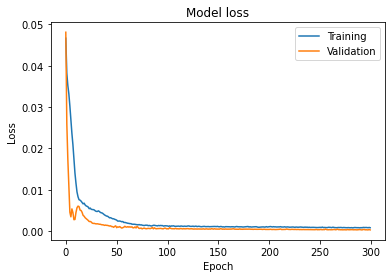

In [70]:
# Plot training data loss vs. validation data loss

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Finally, I predict the test data outcome(s) with our model

I print out the last fifteen of predictions vs. correct labels just so we can visualize the output

In [73]:
from sklearn.metrics import mean_squared_error

# Evaluate the model on test data

y_pred = lstm_model.predict(trim_dataset(x_test_t, batch_size), batch_size=batch_size)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, batch_size)
error = mean_squared_error(y_test_t, y_pred)

print('Error is:', error)

print('Printing last 15 values of predictions and correct labels...')
for i in range(15):
    print('Predicted:', y_pred[i], 'Correct:', y_test_t[i])

Amount of rows to be dropped: 10
Amount of rows to be dropped: 0
Error is: 0.0009055177753432251
Printing last 15 values of predictions and correct labels...
Predicted: 0.7344124 Correct: 0.7313059958649206
Predicted: 0.7377612 Correct: 0.726654031702274
Predicted: 0.7387184 Correct: 0.7352687801516193
Predicted: 0.74599344 Correct: 0.741815988973122
Predicted: 0.7465992 Correct: 0.7344073053066849
Predicted: 0.74388963 Correct: 0.7379393521709168
Predicted: 0.7460728 Correct: 0.7460372157133008
Predicted: 0.74973875 Correct: 0.7468556168159886
Predicted: 0.7519694 Correct: 0.7326843556168154
Predicted: 0.74506885 Correct: 0.7299707098552721
Predicted: 0.74256057 Correct: 0.7273001378359751
Predicted: 0.74388206 Correct: 0.7354841488628532
Predicted: 0.74671537 Correct: 0.7143349414197102
Predicted: 0.7364367 Correct: 0.7055478980013783
Predicted: 0.7282509 Correct: 0.7021019986216399
